In [67]:
import pandas as pd
from sklearn.linear_model import LassoCV, RidgeCV
import numpy as np
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('../data/training_for_GS_122118.csv')
data = data.set_index('FoodCode')

In [23]:
numerical_features = data.columns[1:-1]

In [49]:
correlations = pd.DataFrame(data[numerical_features].corrwith(data['lac.per.100g']),columns=['correlation'])

In [51]:
# correlations

In [24]:
X = data[numerical_features]
X.head()

,KCAL,PROT,TFAT,CARB,MOIS,ALC,CAFF,SUGR,FIBE,CALC,...,P182,P183,P184,P204,P205,P225,P226,VITD,CHOLN,year
FoodCode,,,,,,,,,,,,,,,,,,,,,
11220000,321.0,7.91,8.70,54.40,27.16,0.0,0.0,54.40,0.0,284.0,...,0.216,0.121001,0.0,0.000,0.0,0.0,0.0,0.2,89.1,2014
11516000,49.0,3.64,1.01,6.47,88.01,0.0,0.0,5.92,0.2,135.0,...,0.031,0.004000,0.0,0.000,0.0,0.0,0.0,1.2,19.9,2014
11531000,88.0,4.55,4.19,8.05,82.54,0.0,0.0,8.41,0.0,130.0,...,0.132,0.059000,0.0,0.003,0.0,0.0,0.0,1.2,52.2,2014
11830800,357.0,19.90,1.40,66.20,7.40,0.0,25.0,65.80,0.4,285.0,...,0.247,0.031000,0.0,0.000,0.0,0.0,0.0,0.0,148.4,2014
13210250,83.0,2.75,1.15,15.59,79.53,0.0,2.0,10.28,0.4,101.0,...,0.036,0.014000,0.0,0.000,0.0,0.0,0.0,0.6,10.9,2014


In [26]:
Y = data['lac.per.100g']
Y.head()

FoodCode
11220000    11.45000
11516000     5.79759
11531000     5.13504
11830800    21.31081
13210250     0.22385
Name: lac.per.100g, dtype: float64

In [81]:
# #Compare 100 values of alpha, distributed log-wise over three orders of magnitude
# eps = 1e-3 
# n_alphas = 100 

alphas = np.logspace(-3, 3, 100)

#increase tol by one order above default, otherwise doesn't converge

lasso_CV = LassoCV(alphas=alphas,cv=10,max_iter=1000)

lasso_CV.fit(X,Y)

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Gabriel\AppData\Local\conda\conda\envs\DairyML\lib\site-packa

LassoCV(alphas=array([1.00000e-03, 1.14976e-03, ..., 8.69749e+02, 1.00000e+03]),
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [82]:
mse = np.mean(lasso_CV.mse_path_,axis=1)

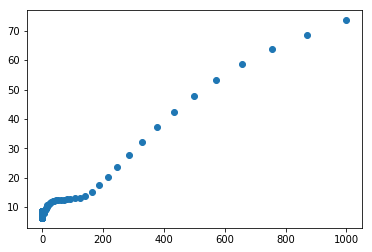

In [83]:
plt.scatter(x=alphas,y=mse,)

In [84]:
lasso_CV.alpha_

6.5793322465756825